In [22]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import scipy.optimize
import sklearn.linear_model
import sys

In [23]:
sys.path.insert(0, '../..')
from src.load_downsampled import calc_peak_power_from_day_of_year

In [2]:
ihl_df = pd.read_hdf('../../data/published_data_vs01/data/dfC_300s.hdf')

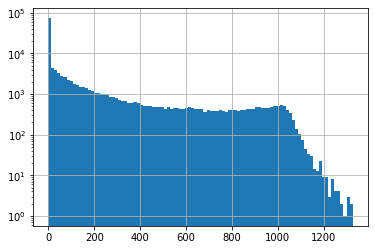

In [3]:
ihl_df['C_solarlog_radiation'].hist(bins=100, log=True);

In [4]:
radiation_array = []
radiation_day_of_year = []
for time, group_df in ihl_df['C_solarlog_radiation'].dropna().groupby(pd.Grouper(freq='1D')):
    if len(group_df) != 24 * 12:
        continue
    radiation_day_of_year.append(time.dayofyear)
    radiation_array.append(group_df.values)
radiation_array = np.stack(radiation_array)
radiation_day_of_year = np.array(radiation_day_of_year)
radiation_array.shape, radiation_day_of_year.shape

((482, 288), (482,))

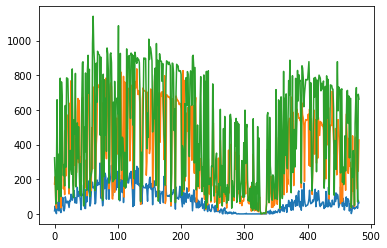

In [5]:
plt.plot(radiation_array[:, 100]);
plt.plot(radiation_array[:, 130]);
plt.plot(radiation_array[:, 144]);

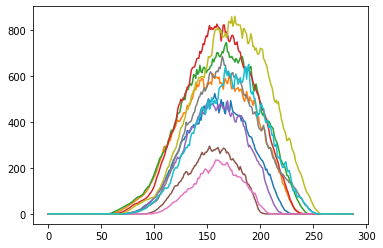

In [6]:
window_size = 50
for i in np.arange(0, len(radiation_array), window_size):
    plt.plot(np.mean(radiation_array[i:i + window_size, :], axis=0));

In [7]:
temp = []
window_size = 3
for i in np.arange(0, len(radiation_array), window_size):
    window = np.mean(radiation_array[i:i + window_size, :], axis=0)
    temp.append({
        'time': (i + window_size / 2) / len(radiation_array),
        'mean': window.mean(),
        'stddev': window.std(),
    })
temp = pd.DataFrame(temp).set_index('time', drop=False)

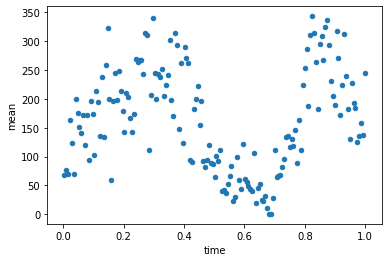

In [8]:
temp.plot.scatter(x='time', y='mean');

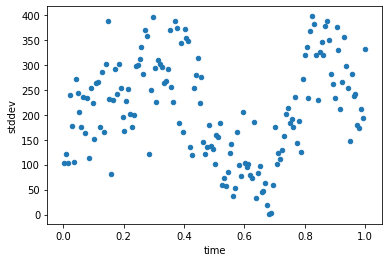

In [9]:
temp.plot.scatter(x='time', y='stddev');

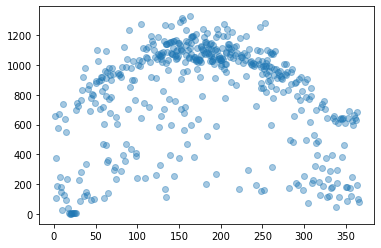

In [10]:
plt.scatter(radiation_day_of_year, radiation_array.max(axis=1), alpha=0.4);

In [11]:
def peak_power_from_day_of_year(day_of_year, mean, amplitude, phase):
    return mean + amplitude * np.cos(day_of_year * 2 * np.pi / 365 + phase)

peak_power_params, _ = scipy.optimize.curve_fit(
    peak_power_from_day_of_year,
    radiation_day_of_year,
    radiation_array.max(axis=1),
    p0=[800, 200, 3],
)
peak_power_params

array([751.46733655, 326.41625985,   3.14902183])

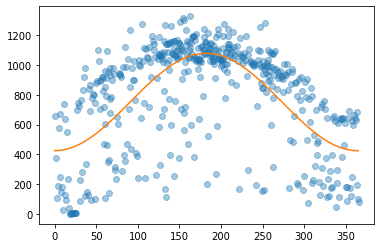

In [12]:
fig, ax = plt.subplots()
ax.scatter(radiation_day_of_year, radiation_array.max(axis=1), alpha=0.4)
temp = np.linspace(0, 365)
ax.plot(temp, peak_power_from_day_of_year(temp, *peak_power_params), c='C1');

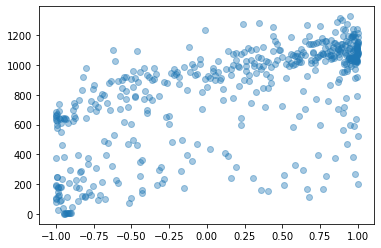

In [13]:
plt.scatter(np.cos(radiation_day_of_year * 2 * np.pi / 365 + peak_power_params[2]), radiation_array.max(axis=1), alpha=0.4);

In [14]:
regressor = sklearn.linear_model.RANSACRegressor()
regressor.fit(
    np.cos(radiation_day_of_year * 2 * np.pi / 365 + peak_power_params[2]).reshape((-1, 1)),
    radiation_array.max(axis=1),
)
peak_power_params = [
    regressor.estimator_.intercept_,
    regressor.estimator_.coef_.item(),
    peak_power_params[2],
]
peak_power_params

[898.66652010348, 225.89250085662403, 3.14902183078918]

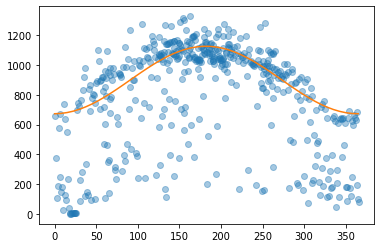

In [15]:
fig, ax = plt.subplots()
ax.scatter(radiation_day_of_year, radiation_array.max(axis=1), alpha=0.4)
temp = np.linspace(0, 365)
ax.plot(temp, peak_power_from_day_of_year(temp, *peak_power_params), c='C1');

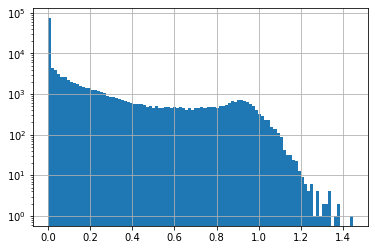

In [21]:
temp = ihl_df['C_solarlog_radiation'].copy()
temp /= peak_power_from_day_of_year(temp.index.dayofyear, *peak_power_params)
temp.hist(bins=100, log=True);

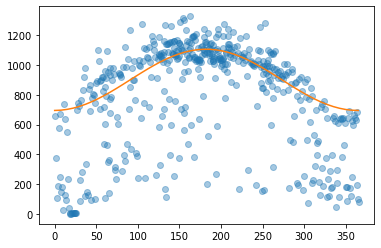

In [24]:
peak_power_from_day_of_year = calc_peak_power_from_day_of_year(
    radiation_array,
    radiation_day_of_year,
)

fig, ax = plt.subplots()
ax.scatter(radiation_day_of_year, radiation_array.max(axis=1), alpha=0.4)
temp = np.linspace(0, 365)
ax.plot(temp, peak_power_from_day_of_year(temp), c='C1');